In [121]:
import torch
from torch.utils.data import Dataset
import os
from pathlib import Path
import torch.nn.functional as F



def reshape_patches_to_spatial_temporal(features, num_frames=13, patch_height=24, patch_width=42):
    """
    Convert flattened patch features back to spatial-temporal grid
    
    Args:
        features: [batch, 13104, feature_dim] or [13104, feature_dim]
        num_frames: 13
        patch_height: 24 (48 // patch_size)
        patch_width: 42 (84 // patch_size)
    
    Returns:
        reshaped_features: [batch, 13, 24, 42, feature_dim] or [13, 24, 42, feature_dim]
    """
    if features.dim() == 2:
        # [13104, feature_dim] → [13, 24, 42, feature_dim]
        return features.view(num_frames, patch_height, patch_width, -1)
    else:
        # [batch, 13104, feature_dim] → [batch, 13, 24, 42, feature_dim]
        batch_size = features.shape[0]
        feature_dim = features.shape[-1]
        return features.view(batch_size, num_frames, patch_height, patch_width, feature_dim)


def resize_depth_to_feature_space(depth, target_frames=13, patch_height=24, patch_width=42):
    """
    Resize depth to match feature dimensions following the original patchification process.
    
    Args:
        depth: [num_frames, 1, height, width] - e.g., [49, 1, 540, 960]
        target_frames: 13 (from feature shape)
        patch_height: 24 (from feature shape) 
        patch_width: 42 (from feature shape)
    
    Returns:
        resized_depth: [target_frames, patch_height, patch_width]
    """
    # Ensure we have the right format: [batch, channels, frames, height, width]
    if depth.dim() == 4:  # [49, 1, 540, 960]
        # Rearrange to [1, 1, 49, 540, 960] for trilinear interpolation
        depth = depth.permute(1, 0, 2, 3).unsqueeze(0)
    elif depth.dim() == 3:  # [49, 540, 960]
        # Add batch and channel dimensions: [1, 1, 49, 540, 960]
        depth = depth.unsqueeze(0).unsqueeze(0)
    
    # print(f"Depth shape before interpolation: {depth.shape}")
    
    # Temporal + spatial downsampling to match patch dimensions
    resized_depth = F.interpolate(
        depth,
        size=(target_frames, patch_height, patch_width),
        mode='trilinear',
        align_corners=False
    )
    
    # Remove batch and channel dimensions: [1, 1, 13, 24, 42] → [13, 24, 42]
    return resized_depth.squeeze(0).squeeze(0)

def normalize_features_per_channel(features):
    """
    features: [1, 13104, 3072] 
    Normalize each of the 3072 feature dimensions independently
    """
    # Method 1: Using broadcasting
    mean_per_channel = features.mean(dim=1, keepdim=True)  # [1, 1, 3072]
    std_per_channel = features.std(dim=1, keepdim=True)    # [1, 1, 3072]
    
    normalized_features = (features - mean_per_channel) / (std_per_channel + 1e-8)

    return normalized_features


class DepthProbingDataset(Dataset):
    def __init__(self, root_dir, timestep, feature_name):
        """
        Args:
            root_dir: Root directory containing all monkaa_* folders
            timestep: Feature timestep (e.g., 39)
            feature_name: Feature file name (e.g., 'cross_attn_0')
        """
        self.root_dir = Path(root_dir)
        self.timestep = timestep
        self.feature_name = feature_name
        
        # Find all dataset entries (monkaa_*)
        self.entries = sorted([d for d in self.root_dir.iterdir() 
                              if d.is_dir() and d.name.startswith('monkaa_')])
        
        # Validate that required files exist
        self.valid_entries = []
        for entry in self.entries:
            depth_path = entry / 'depths' / 'depths.pt'
            feature_path = entry / 'features' / f'{timestep}' / f'{feature_name}.pt'
            if depth_path.exists() and feature_path.exists():
                self.valid_entries.append(entry)
        
        print(f"Found {len(self.valid_entries)} valid entries")
    
    def __len__(self):
        return len(self.valid_entries)
    
    def __getitem__(self, idx):
        entry = self.valid_entries[idx]
        
        # Load depth
        depth_path = entry / 'depths' / 'depths.pt'
        depth = torch.load(depth_path, weights_only=True)
        
        # bug: keep last 49 frames
        depth = depth[10:]
        
        # log normalize depth
        depth = torch.log1p(depth)
        
        # Load features
        feature_path = entry / 'features' / f'{self.timestep}' / f'{self.feature_name}.pt'
        features = torch.load(feature_path, weights_only=True).float()
        
        # Normalize features per channel
        features = normalize_features_per_channel(features)
        
        
        # Resize depth and features to same spatial-temporal dimensions
        features = reshape_patches_to_spatial_temporal(features)[0]
        depth_resized = resize_depth_to_feature_space(depth)
        
        return {
            'features': features,
            'depth': depth_resized,
            'entry_name': entry.name
        }


In [158]:
dataset = DepthProbingDataset(
    '/home/azhuravl/scratch/linear_probing',
    'timestep_839', 
    'transformer_block_24'
    )

Found 250 valid entries


In [159]:
data_10 = dataset[40]

In [160]:
print('depth', data_10['depth'].min(), data_10['depth'].max())
print('features', data_10['features'].min(), data_10['features'].max())

depth tensor(2.7899) tensor(6.7337)
features tensor(-6.8287) tensor(6.7283)


In [161]:
data_10['depth'].shape

torch.Size([13, 24, 42])

In [162]:
data_10['features'].shape

torch.Size([13, 24, 42, 3072])

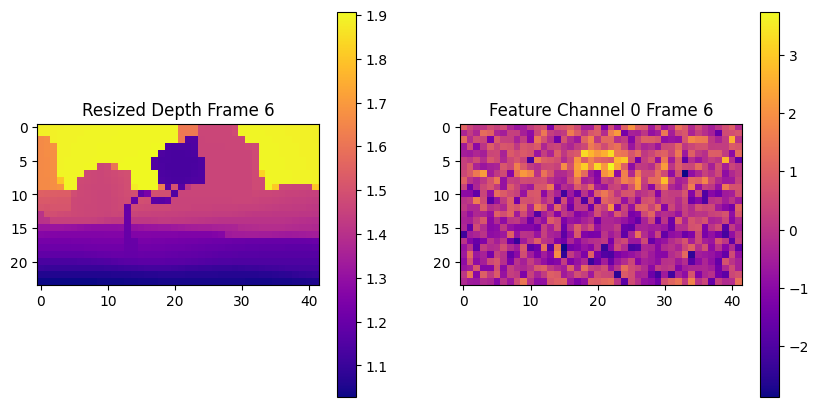

In [163]:
# plot depth and features for frame 6, feature channel 0
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(torch.log(data_10['depth'][6].cpu()), cmap='plasma')
axs[0].set_title('Resized Depth Frame 6')
plt.colorbar(im0, ax=axs[0])  # Specify which axes the colorbar belongs to

im1 = axs[1].imshow(data_10['features'][6, :, :, 50].cpu(), cmap='plasma')
axs[1].set_title('Feature Channel 0 Frame 6')
plt.colorbar(im1, ax=axs[1])  # Specify which axes the colorbar belongs to

plt.show()

## Training Loop

In [164]:
import torch.nn as nn

class ConvProbe(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_dim, 1, kernel_size=1)
        # self.norm = nn.LayerNorm(in_dim)

    # def forward(self, feats):
    #     # feats: [B, H, W, C]
    #     feats = feats.permute(0, 3, 1, 2)     # [B, C, H, W]
    #     depth = self.proj(feats)              # [B, 1, H, W]
    #     return depth.squeeze(1)

    def forward(self, feats):
        # feats: [B, T, H, W, C]
        B, T, H, W, C = feats.shape
        
        # Reshape to process all frames at once
        feats = feats.view(B * T, H, W, C)    # [B*T, H, W, C]
        feats = feats.permute(0, 3, 1, 2)     # [B*T, C, H, W]
        
        # feats = self.norm(feats)
        depth = self.proj(feats)              # [B*T, 1, H, W]
        depth = depth.squeeze(1)              # [B*T, H, W]
        
        # Reshape back to temporal format
        depth = depth.view(B, T, H, W)        # [B, T, H, W]
        return depth

In [165]:
# Preload training data (first 200 entries)
print("Preloading training data...")
train_data = []
for i in tqdm(range(min(200, len(dataset)))):
    data_i = dataset[i]
    train_data.append({
        'features': data_i['features'].clone(),  # Clone to avoid reference issues
        'depth': data_i['depth'].clone(),
        'entry_name': data_i['entry_name']
    })

# Preload test data (entries 200-250)
print("Preloading test data...")
test_data = []
for i in tqdm(range(200, min(250, len(dataset)))):
    data_i = dataset[i]
    test_data.append({
        'features': data_i['features'].clone(),
        'depth': data_i['depth'].clone(),
        'entry_name': data_i['entry_name']
    })

print(f"Loaded {len(train_data)} training samples, {len(test_data)} test samples")

Preloading training data...


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]


Preloading test data...


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]

Loaded 200 training samples, 50 test samples


In [166]:
import random
from tqdm import tqdm

# Training loop with shuffling
probe = ConvProbe(3072).cuda()
optimizer = torch.optim.Adam(probe.parameters(), lr=1e-3)
criterion = nn.MSELoss()
losses = []

Epoch 10 Loss: 6.3135: 100%|██████████| 200/200 [00:03<00:00, 59.53it/s]


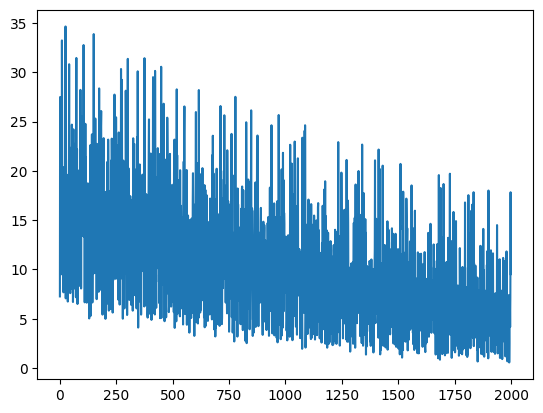

In [167]:
# Training with shuffled indices
for epoch in range(10):
    # Create shuffled indices
    indices = list(range(len(train_data)))
    random.shuffle(indices)
    
    iterator = tqdm(indices, desc=f"Epoch {epoch+1}")
    for idx in iterator:
        data_i = train_data[idx]
        feats = data_i['features'].unsqueeze(0).cuda()
        depth_gt = data_i['depth'].unsqueeze(0).cuda()
        
        pred = probe(feats)
        loss = criterion(pred, depth_gt)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        iterator.set_description(f"Epoch {epoch+1} Loss: {sum(losses[-10:]) / len(losses[-10:]):.4f}")
        
plt.plot(losses)

In [168]:
# Evaluation function
def evaluate_probe(probe, data, data_name=""):
    probe.eval()
    losses = []
    predictions = []
    ground_truths = []
    
    with torch.no_grad():
        for data_i in tqdm(data, desc=f"Evaluating {data_name}"):
            feats = data_i['features'].unsqueeze(0).cuda()
            depth_gt = data_i['depth'].unsqueeze(0).cuda()
            
            pred = probe(feats)
            loss = criterion(pred, depth_gt)
            
            losses.append(loss.item())
            predictions.append(pred.cpu())
            ground_truths.append(depth_gt.cpu())
    
    avg_loss = sum(losses) / len(losses)
    return avg_loss, predictions, ground_truths


In [169]:
# Evaluate on both train and test sets
print("Evaluating on training set...")
train_loss, train_preds, train_gts = evaluate_probe(probe, train_data, "Train")

print("Evaluating on test set...")
test_loss, test_preds, test_gts = evaluate_probe(probe, test_data, "Test")

print(f"\nTrain Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Generalization Gap: {test_loss - train_loss:.4f}")

Evaluating on training set...


Evaluating Train: 100%|██████████| 200/200 [00:04<00:00, 46.42it/s]


Evaluating on test set...


Evaluating Test: 100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


Train Loss: 5.8139
Test Loss: 7.4164
Generalization Gap: 1.6025


Sample 0: Mean Absolute Relative Error: 51.58%


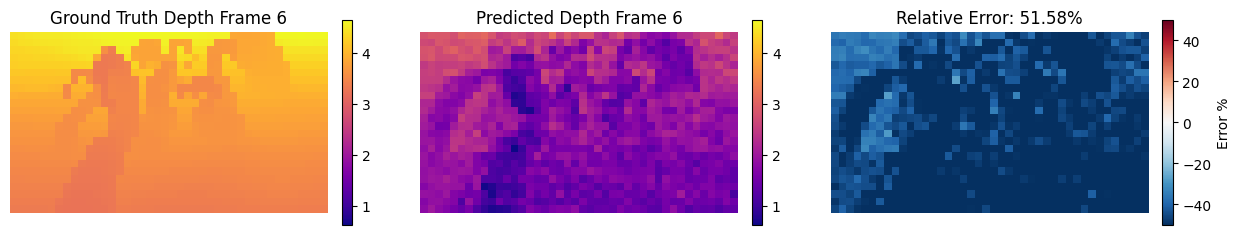

Sample 25: Mean Absolute Relative Error: 63.87%


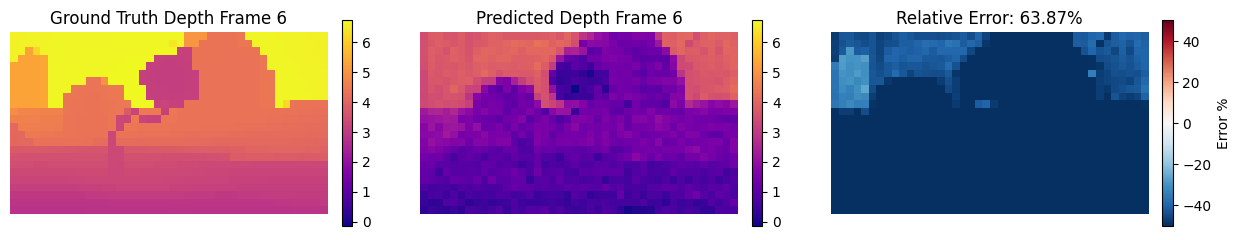

Sample 45: Mean Absolute Relative Error: 63.38%


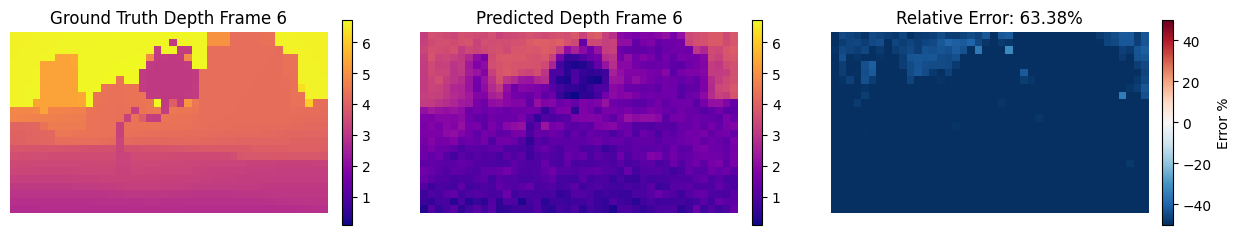

In [ ]:
import numpy as np

# Visualize some predictions
ids_vis = [0, 25, 45]

for idx in ids_vis:
    # plot gt, pred, difference for frame 6 only. use same color scale
    gt_depth = test_gts[idx][0, 6].squeeze().numpy()
    pred_depth = test_preds[idx][0, 6].squeeze().numpy()
    
    # Calculate relative error in percentage
    # Avoid division by zero by adding small epsilon
    epsilon = 1e-8
    rel_error = ((pred_depth - gt_depth) / (gt_depth + epsilon)) * 100
    
    vmin = min(gt_depth.min(), pred_depth.min())
    vmax = max(gt_depth.max(), pred_depth.max())
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Ground truth
    im0 = axs[0].imshow(gt_depth, cmap='plasma', vmin=vmin, vmax=vmax)
    axs[0].set_title('Ground Truth Depth Frame 6')
    plt.colorbar(im0, ax=axs[0], fraction=0.03, pad=0.04)
    # remove axes
    axs[0].axis('off')
    
    # Prediction
    im1 = axs[1].imshow(pred_depth, cmap='plasma', vmin=vmin, vmax=vmax)
    axs[1].set_title('Predicted Depth Frame 6')
    plt.colorbar(im1, ax=axs[1], fraction=0.03, pad=0.04)
    axs[1].axis('off')
    
    # Print some statistics
    mean_abs_rel_error = np.abs(rel_error).mean()
    print(f"Sample {idx}: Mean Absolute Relative Error: {mean_abs_rel_error:.2f}%")
    
    
    # Relative error in percentage
    im2 = axs[2].imshow(rel_error, cmap='RdBu_r', vmin=-50, vmax=50)  # Symmetric range
    axs[2].set_title(f'Relative Error: {mean_abs_rel_error:.2f}%')
    plt.colorbar(im2, ax=axs[2], label='Error %', fraction=0.03, pad=0.04)
    axs[2].axis('off')
    
    plt.show()